# ロボットインテリジェンス　レポート課題
# ・ニューラルネットワークの実装
# ・中間層の役割とニューロンの最適刺激
### ライブラリのインポート

In [2]:
#coding: utf-8
import numpy as np
import sys
import os
import os.path

from collections import OrderedDict
import matplotlib.pyplot as plt

sys.path.append(os.pardir)
from dataset.mnist import load_mnist

## 各種関数の実装
シグモイド関数とその微分、ReLUとその微分、Softmax関数、交差エントロピー誤差、二乗平均誤差  
をそれぞれ作っている

In [143]:
def sigmoid(x):
    return 1 / (1+np.exp(x))

def sigmoid_d(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def relu(x):
    return np.maximum(0, x)

def relu_d(x):
    grad = np.zeros_like(x)
    grad[x>=0] = 1
    return grad

def softmax(x):
    x = x - np.max(x, axis=-1, keepdims=True) # オーバーフロー防止用
    return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)

# 交差エントロピー誤差
def cross_entropy_error(prob, t):
    
    if prob.ndim == 1:
        t = t.reshape(1, prob.size)
        prob = prob.reshape(1, prob.size)
        
    if t.size == prob.size:
        t = t.argmax(axis=1)
             
    batch_size = prob.shape[0]
    
    return -np.mean(np.log(prob[np.arange(prob.shape[0]), t] + 1e-7))

# 二乗平均誤差
def root_square_mean_error(y, t):
    return 0.5 * np.sum((y-t)**2) # 比較には平方根はいらない

## 学習のトリック
学習のトリックについてクラスを用いて表している
SGDは一般的な学習則を表している

In [73]:
class SGD:

    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for k in params.keys():
            params[k] -= self.lr * grads[k] 


class Momentum:

    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for k, value in params.items():                                
                self.v[k] = np.zeros(value.shape)
                
        for k in params.keys():
            self.v[k] = self.momentum * self.v[k] - self.lr * grads[k] 
            params[k] = params[k] + self.v[k]
            
class AdaGrad:

    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, value in params.items():
                self.h[key] = np.zeros(value.shape)
            
        for k in params.keys():
            self.h[k] = self.h[k] + grads[k] * grads[k]
            params[k] -= self.lr * grads[k] / (np.sqrt(self.h[k]) + 1e-7)

### レイヤの実装
ここでは活性化関数とそれらを繋ぐノードに用いる行列積をレイヤとしてクラス単位で実装する  
どのレイヤについてもforwardメソッドで順伝播を実装し、backwardメソッドで逆伝播を実装している  
Softmax関数については必ず出力層に用いるので損失も合わせて実装している
誤差関数については引数error_typeによって、二乗平均誤差もしくは交差エントロピー誤差のいずれかを用いることができる。

In [30]:
# 行列積を伝えるレイヤ
class Linear_Layer:
    def __init__(self, W, b):
        #super().__init__(Linear_Layer)
        self.W = W
        self.b = b
        self.x = None
        self.W_grad = None
        self.b_grad = None
        
    def forward(self, x):
        self.x = x
        return np.dot(x, self.W) + self.b
    
    def backward(self, dout):
        self.W_grad = np.dot(self.x.T, dout)
        self.b_grad = np.sum(dout, axis=0)
        return np.dot(dout, self.W.T)

# 活性化関数がシグモイド
class Sigmoid_Layer:
    def __init__(self):
        #super().__init__(Sigmoid_Layer)
        self.out = None
    
    def forward(self, x):
        self.out = sigmoid(x)
        return self.out
    
    def backward(self, dout):
        return dout * (1.0 - self.out) * self.out

# 活性化関数がReLU    
class ReLU_Layer:
    def __init__(self):
        #super().__init__(ReLU_Layer)
        self.mask = None
    
    def forward(self, x):
        out = np.maximum(x, 0)
        self.mask = np.sign(out)
        return out
    
    def backward(self, dout):
        return self.mask * dout
    
# 活性化関数がSoftmax, 出力層に用いるので損失と組み合わせる
# error_type {1:二乗平均誤差, 2:交差エントロピー誤差}
class Softmax_Loss_Layer:
    def __init__(self, error_type=1):
        #super().__init__(Softmax_Loss_Layer)
        self.loss = None
        self.y = None
        self.t = None
        self.error_type = error_type
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        if self.error_type == 1:
            self.loss = root_square_mean_error(self.y, self.t) # 二乗平均誤差
        elif self.error_type == 2:
            self.loss = cross_entropy_error(self.y, self.t) # 交差エントロピー誤差
        else:
            print("error_type should be 1 or 2")
            
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx
            


## ３層ニューラルネットワークの実装
initでは結合荷重初期値の決定とニューラルネットワークの構築を行っている  
ディクショナリにすることで層のつながる順番を表せるようにしている  
活性化関数により結合荷重の初期値を変化させられるように実装した

predictでは順伝播により入力から出力方向への処理を実装、  
gradientで逆伝播により勾配を求めている  
accuracyでは正解率の計算、lossで損失の微分を計算している

In [144]:
class NeuralNet_3layer:

    def __init__(self, input_size, hidden_size, output_size, weight_init_value = 0.01,
                activate_func="relu"):
        # 重みの初期化
        # ガウス分布を用いた乱数設定(通常バージョン)
        if activate_func == "normal":
            self.params = {}
            self.params['W1'] = weight_init_value * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = weight_init_value * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)
        
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['ReLU1'] = ReLU_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])
        
        # ReLUを用いたときの重み初期値
        elif activate_func == "relu":
            scale_in = np.sqrt(2.0 / input_size)
            scale_hidden = np.sqrt(2.0 / hidden_size)
            #scale_out = np.sqrt(2.0 / output_size)
            
            self.params = {}
            self.params['W1'] = scale_in * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = scale_hidden * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)    
            
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['ReLU1'] = ReLU_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])
            
        # Sigmoidを用いたときの重み初期値
        elif activate_func == "sigmoid":
            scale_in = np.sqrt(1.0 / input_size)
            scale_hidden = np.sqrt(1.0 / hidden_size)
            #scale_out = np.sqrt(2.0 / output_size)
            
            self.params = {}
            self.params['W1'] = scale_in * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = scale_hidden * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)
            
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['Sigmoid1'] = Sigmoid_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])

        self.OutputLayer = Softmax_Loss_Layer(2)
        
    def predict(self, x):
        for l in self.layers.values():
            x = l.forward(x)        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.OutputLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # 逆伝播による勾配の実装
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.OutputLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Linear1'].W_grad, self.layers['Linear1'].b_grad
        grads['W2'], grads['b2'] = self.layers['Linear2'].W_grad, self.layers['Linear2'].b_grad

        return grads

In [70]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

net_3 = NeuralNet_3layer(input_size=784, hidden_size=50, output_size=10,activate_func="normal")

iters_num = 10000 
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 勾配
    grad = net_3.gradient(x_batch, t_batch)
    
    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        
        net_3.params[key] -= learning_rate * grad[key]
    
    loss = net_3.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    if i % iter_per_epoch == 0:
        print("epoch: {}".format(i//iter_per_epoch))
        train_acc = net_3.accuracy(x_train, t_train)
        test_acc = net_3.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)
print(train_acc_list[-1], test_acc_list[-1])

epoch: 0.0
0.09468333333333333 0.089
epoch: 1.0
0.9048 0.9056
epoch: 2.0
0.9210166666666667 0.9225
epoch: 3.0
0.93185 0.9323
epoch: 4.0
0.9440333333333333 0.9416
epoch: 5.0
0.9501333333333334 0.9476
epoch: 6.0
0.956 0.9521
epoch: 7.0
0.9610166666666666 0.9584
epoch: 8.0
0.96455 0.9621
epoch: 9.0
0.9681333333333333 0.9617
epoch: 10.0
0.9698 0.9653
epoch: 11.0
0.9721666666666666 0.9674
epoch: 12.0
0.97395 0.9674
epoch: 13.0
0.9750166666666666 0.9694
epoch: 14.0
0.9747833333333333 0.9692
epoch: 15.0
0.9785833333333334 0.9702
epoch: 16.0
0.97825 0.9691
0.97825 0.9691


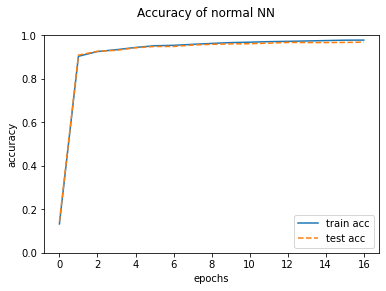

In [33]:
# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.suptitle("Accuracy of normal NN")
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.savefig("neuralnet_normal.png")
plt.show()

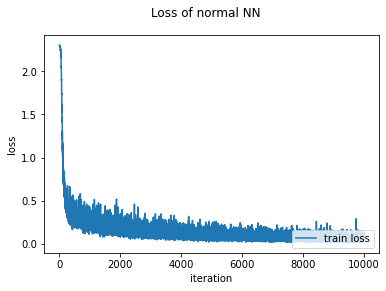

In [40]:
x = np.array(range(10000))
plt.suptitle("Loss of normal NN")
plt.plot(x, train_loss_list, label='train loss')
plt.xlabel("iteration")
plt.ylabel("loss")
#plt.xlim(0,2000)
plt.legend(loc='lower right')
plt.savefig("loss")
plt.show()

損失が減少していることから学習が進んでいると考えられる。

In [74]:
class NeuralNet_3layer_improve:

    def __init__(self, input_size, hidden_size, output_size, weight_init_value = 0.01,
                activate_func="relu", weight_decay_rate=5e-4):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.activate_func = activate_func
        self.weight_decay_rate = weight_decay_rate
        
        # 重みの初期化
        # ガウス分布を用いた乱数設定(通常バージョン)
        if activate_func == "normal":
            self.params = {}
            self.params['W1'] = weight_init_value * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = weight_init_value * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)
        
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['ReLU1'] = ReLU_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])
        
        # ReLUを用いたときの重み初期値
        elif activate_func == "relu":
            scale_in = np.sqrt(2.0 / input_size)
            scale_hidden = np.sqrt(2.0 / hidden_size)
            #scale_out = np.sqrt(2.0 / output_size)
            
            self.params = {}
            self.params['W1'] = scale_in * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = scale_hidden * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)    
            
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['ReLU1'] = ReLU_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])
            
        # Sigmoidを用いたときの重み初期値
        elif activate_func == "sigmoid":
            scale_in = np.sqrt(1.0 / input_size)
            scale_hidden = np.sqrt(1.0 / hidden_size)
            #scale_out = np.sqrt(2.0 / output_size)
            
            self.params = {}
            self.params['W1'] = scale_in * np.random.randn(input_size, hidden_size)
            self.params['b1'] = np.zeros(hidden_size)
            self.params['W2'] = scale_hidden * np.random.randn(hidden_size, output_size) 
            self.params['b2'] = np.zeros(output_size)
            
            self.layers = OrderedDict()
            self.layers['Linear1'] = Linear_Layer(self.params['W1'], self.params['b1'])
            self.layers['Sigmoid1'] = Sigmoid_Layer()
            self.layers['Linear2'] = Linear_Layer(self.params['W2'], self.params['b2'])

        self.OutputLayer = Softmax_Loss_Layer(2)
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        weight_decay = 0
        
        for idx in range(1, 3):
            W = self.params['W' + str(idx)]
            weight_decay += 0.5 * self.weight_decay_rate * np.sum(W ** 2)
        
        return self.OutputLayer.forward(y, t) + weight_decay
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : 
            t = np.argmax(t, axis=1)        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # 逆伝播による勾配の実装
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.OutputLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Linear1'].W_grad, self.layers['Linear1'].b_grad
        grads['W2'], grads['b2'] = self.layers['Linear2'].W_grad, self.layers['Linear2'].b_grad

        return grads

In [131]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_acc_list_hsize1to100 = []
test_acc_list_hsize1to100 = []
for i in [1,5,10,20,30,40,50,60,70,80,90,100]:
    net_3_improve = NeuralNet_3layer_improve(input_size=784, hidden_size=i, output_size=10,activate_func="relu")

    optimizer = SGD()
    iteration_num = 10000 
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.1

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iteration_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        grad = net_3_improve.gradient(x_batch, t_batch)
        optimizer.update(net_3_improve.params, grad)
        
    
        loss = net_3_improve.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
            #print("epoch: {}".format(i//iter_per_epoch))
            train_acc = net_3_improve.accuracy(x_train, t_train)
            test_acc = net_3_improve.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    train_acc_list_hsize1to100.append(train_acc_list[-1])
    test_acc_list_hsize1to100.append(test_acc_list[-1])
    print(train_acc_list[-1], test_acc_list[-1])

0.26611666666666667 0.2642
0.86705 0.8669
0.9175166666666666 0.9179
0.9270166666666667 0.9278
0.9286333333333333 0.9287
0.93535 0.9344
0.9328166666666666 0.9347
0.93575 0.9335
0.9328166666666666 0.9328
0.9401166666666667 0.9388
0.9370166666666667 0.9366
0.9381666666666667 0.9373


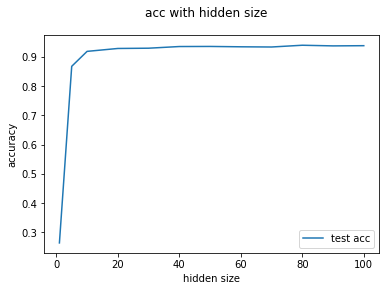

In [133]:
x = [1,5,10,20,30,40,50,60,70,80,90,100]
plt.suptitle("acc with hidden size")
plt.plot(x, test_acc_list_hsize1to100, label='test acc')
plt.xlabel("hidden size")
plt.ylabel("accuracy")
#plt.xlim(0,2000)
plt.legend(loc='lower right')
plt.savefig("acc_with_hidden_size_1to100.png")
plt.show()

↑上の結果より隠れ層の数が5個より少なくなると識別能力を維持できないと考えられる  
よって次に隠れ層が1から10の間で検証してみる

隠れ層が1から10の間で検証する

In [123]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_acc_list_hsize1to10 = []
test_acc_list_hsize1to10 = []
for i in range(1,11):
    net_3_improve = NeuralNet_3layer_improve(input_size=784, hidden_size=i, output_size=10,activate_func="relu")

    optimizer = SGD()
    iteration_num = 10000 
    train_size = x_train.shape[0]
    batch_size = 100
    learning_rate = 0.1

    train_loss_list = []
    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)

    for i in range(iteration_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        grad = net_3_improve.gradient(x_batch, t_batch)
        optimizer.update(net_3_improve.params, grad)
        
    
        loss = net_3_improve.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        
        if i % iter_per_epoch == 0:
            #print("epoch: {}".format(i//iter_per_epoch))
            train_acc = net_3_improve.accuracy(x_train, t_train)
            test_acc = net_3_improve.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)
    train_acc_list_hsize1to10.append(train_acc_list[-1])
    test_acc_list_hsize1to10.append(test_acc_list[-1])
    print(train_acc_list[-1], test_acc_list[-1])

0.3019 0.3047
0.5187333333333334 0.5258
0.7051333333333333 0.7059
0.82775 0.8308
0.8480833333333333 0.85
0.8792 0.8781
0.8963666666666666 0.8982
0.9088333333333334 0.9097
0.9088166666666667 0.91
0.9167 0.9176


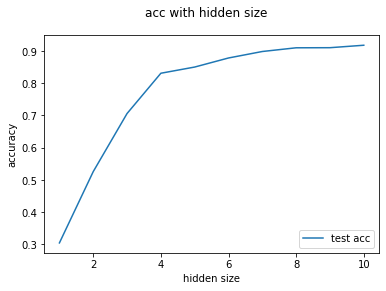

In [127]:
x = np.array(range(10))
plt.suptitle("acc with hidden size")
plt.plot(x+1, test_acc_list_hsize1to10, label='test acc')
plt.xlabel("hidden size")
plt.ylabel("accuracy")
#plt.xlim(0,2000)
plt.legend(loc='lower right')
plt.savefig("acc_with_hidden_size_1to10.png")
plt.show()

上の結果より識別能力が維持できる隠れ層の最小のニューロン数は4または5または6付近となると考えられる  
次にそのときの重みベクトルとの内積がが最大となる入力ベクトルの画像を見てみたい  
内積が最大になるとき、ベクトルは平行となっていることから、入力ベクトルが重みベクトルの実数倍となっている場合だと考えられる。
よって今ここでは重みベクトルの画像を見ることで最大となる入力ベクトルの画像について検証してみたい。
ここではまず隠れ層の最小のニューロン数を6として検証してみたい。

### 隠れ層のニューロン数を6とした場合

In [93]:
net_3_improve_6_hidden = NeuralNet_3layer_improve(input_size=784, hidden_size=6, output_size=10,activate_func="relu")

optimizer = SGD()
iteration_num = 10000 
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iteration_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = net_3_improve_6_hidden.gradient(x_batch, t_batch)
    optimizer.update(net_3_improve_6_hidden.params, grad)
        
    
    loss = net_3_improve_6_hidden.loss(x_batch, t_batch)
    train_loss_list.append(loss)
        
    if i % iter_per_epoch == 0:
        #print("epoch: {}".format(i//iter_per_epoch))
        train_acc = net_3_improve_6_hidden.accuracy(x_train, t_train)
        test_acc = net_3_improve_6_hidden.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
train_acc_list_hsize.append(train_acc_list[-1])
test_acc_list_hsize.append(test_acc_list[-1])
print(train_acc_list[-1], test_acc_list[-1])
print("done")

0.8853 0.8863
done


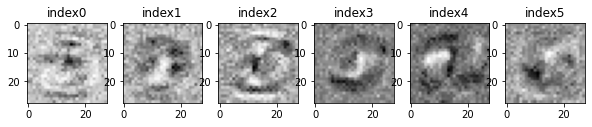

In [113]:
W1 = net_3_improve_6_hidden.params['W1']
plt.figure(figsize=(10,5))
for index in range(W1.shape[1]):
    W1_idx = W1[:, index]
    W1_idx = W1_idx.reshape(28, 28)
    plt.subplot(1,6, index+1)
    plt.title("index{}".format(index))
    plt.imshow(W1_idx, cmap="Greys")
plt.savefig("Optimal_Stimulation_6hidden.png")
plt.show();

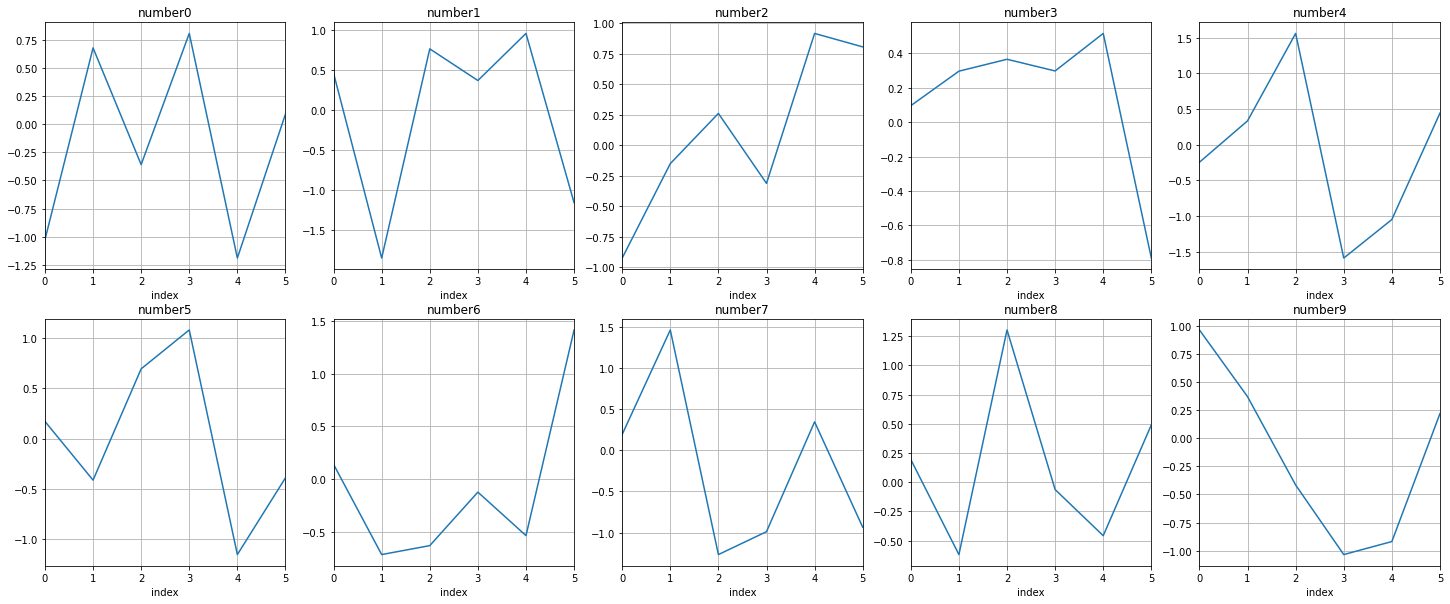

In [117]:
W2 = net_3_improve_6_hidden.params['W2']
plt.figure(figsize=(25,10))
for index in range(W2.shape[1]):
    W2_idx = W2[:, index]
    plt.subplot(2, 5, index+1)
    plt.plot(W2_idx)
    plt.grid()
    plt.xlabel("index")
    plt.title("number{}".format(index))
    plt.xlim(0,5)
plt.savefig("effect_of_weight_6hidden.png")
plt.show()

### 次に隠れ層のニューロン数が5の場合を検証する

In [111]:
net_3_improve_5_hidden = NeuralNet_3layer_improve(input_size=784, hidden_size=5, output_size=10,activate_func="relu")

optimizer = SGD()
iteration_num = 10000 
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iteration_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = net_3_improve_5_hidden.gradient(x_batch, t_batch)
    optimizer.update(net_3_improve_5_hidden.params, grad)
        
    
    loss = net_3_improve_5_hidden.loss(x_batch, t_batch)
    train_loss_list.append(loss)
        
    if i % iter_per_epoch == 0:
        #print("epoch: {}".format(i//iter_per_epoch))
        train_acc = net_3_improve_5_hidden.accuracy(x_train, t_train)
        test_acc = net_3_improve_5_hidden.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
train_acc_list_hsize.append(train_acc_list[-1])
test_acc_list_hsize.append(test_acc_list[-1])
print(train_acc_list[-1], test_acc_list[-1])
print("done")

0.8825666666666667 0.8841
done


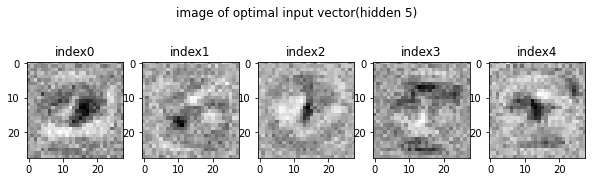

In [148]:
W1 = net_3_improve_5_hidden.params['W1']
plt.figure(figsize=(10,3))
plt.suptitle("image of optimal input vector(hidden 5)")
for index in range(W1.shape[1]):
    W1_idx = W1[:, index]
    W1_idx = W1_idx.reshape(28, 28)
    plt.subplot(1,5, index+1)
    plt.title("index{}".format(index))
    plt.imshow(W1_idx, cmap="Greys")
plt.savefig("Optimal_Stimulation_5hidden.png")
plt.show();

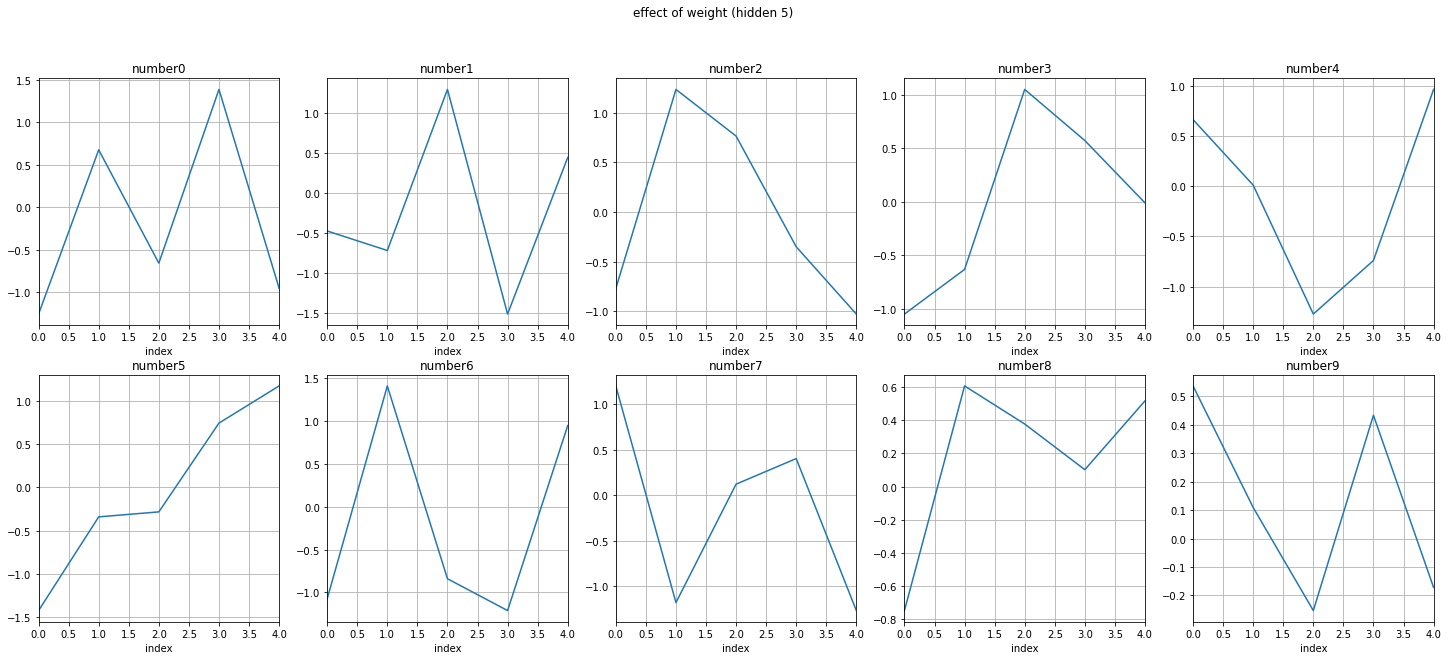

In [149]:
W2 = net_3_improve_5_hidden.params['W2']
plt.figure(figsize=(25,10))
plt.suptitle("effect of weight (hidden 5)")
for index in range(W2.shape[1]):
    W2_idx = W2[:, index]
    plt.subplot(2, 5, index+1)
    plt.plot(W2_idx)
    plt.grid()
    plt.xlabel("index")
    plt.title("number{}".format(index))
    plt.xlim(0,4)
plt.savefig("effect_of_weight_5hidden.png")
plt.show()

### 最後に隠れ層のニューロン数が4の場合を調べる

In [126]:
net3_improve_4_hidden = NeuralNet_3layer_improve(input_size=784, hidden_size=4, output_size=10,activate_func="relu")

optimizer = SGD()
iteration_num = 10000 
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iteration_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grad = net3_improve_4_hidden.gradient(x_batch, t_batch)
    optimizer.update(net3_improve_4_hidden.params, grad)
        
    
    loss = net3_improve_4_hidden.loss(x_batch, t_batch)
    train_loss_list.append(loss)
        
    if i % iter_per_epoch == 0:
        #print("epoch: {}".format(i//iter_per_epoch))
        train_acc = net3_improve_4_hidden.accuracy(x_train, t_train)
        test_acc = net3_improve_4_hidden.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
train_acc_list_hsize.append(train_acc_list[-1])
test_acc_list_hsize.append(test_acc_list[-1])
print(train_acc_list[-1], test_acc_list[-1])
print("done")

0.7507333333333334 0.7484
done


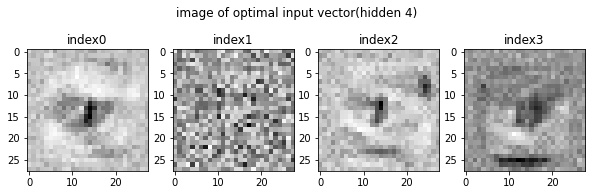

In [151]:
W1 = net3_improve_4_hidden.params['W1']
plt.figure(figsize=(10,3))
plt.suptitle("image of optimal input vector(hidden 4)")
for index in range(W1.shape[1]):
    W1_idx = W1[:, index]
    W1_idx = W1_idx.reshape(28, 28)
    plt.subplot(1,4, index+1)
    plt.title("index{}".format(index))
    plt.imshow(W1_idx, cmap="Greys")
plt.savefig("Optimal_Stimulation_4hidden.png")
plt.show();

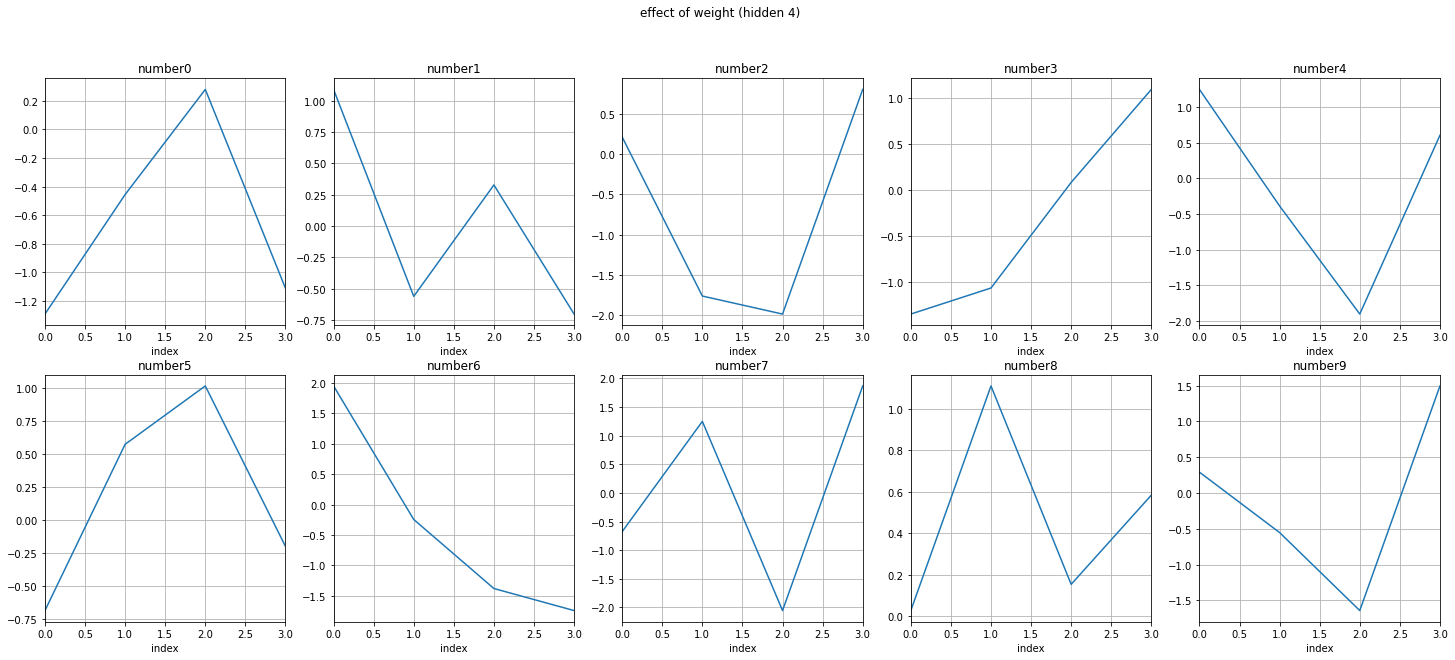

In [155]:
W2 = net3_improve_4_hidden.params['W2']
plt.figure(figsize=(25,10))
plt.suptitle("effect of weight (hidden 4)")
for index in range(W2.shape[1]):
    W2_idx = W2[:, index]
    plt.subplot(2, 5, index+1)
    plt.plot(W2_idx)
    plt.grid()
    plt.xlabel("index")
    plt.title("number{}".format(index))
    plt.xlim(0,3)
plt.savefig("effect_of_weight_4hidden.png")
plt.show()